# Do People Love Their Pets More Than Their Children?: 
# A Topic Analysis of Amazon Reviews

## Introduction
Studies have shown that pets and babies evoke similar emotional responses in the brains of mothers.  Research has shown that children have better relationships with their pets than they do with their siblings.  Pope Francis has expressed concern about the number of married couples choosing to forego having children in favour of having pets.

This project will perform a topic analysis of Amazon reviews of both baby products and pet supplies to see if there is any evidence of an equla or greater love of our pets than our children in the way in which we evaluate the products we buy for them.

## Methodology
Before beginning this task, we must decide on how we are going to measure love - a difficult proposition to be sure!  For the purposes of this analysis, we will consider product reviews that focus on the practical qualities of a product (safety, health) and constrast them with reviews that instead focus on more superficial qualities (price, appearance).

We will use a Latent Dirichlet Allocation (LDA) model to cluster reviews into various topics that we will infer from key words.  We will then compare the most popular topics across each group using our practical vs. superficial model above.   

## Assumptions
The LDA model assumes that each document (in this case, the entire corpus of reviews) is made up of a particular set of topics.  It is also assumed that each topic is a collection of words that each has a probability of appearing within the text.

Considering that each of our product groupings contains a finite number of product types and each product has a finite number of qualities to describe it, I believe that these are reasonable assumption to make here.

With that said, let's look at our data.

In [1]:
import pandas as pd
import gzip
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
import gensim
import nltk
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# Import the data.

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

baby = getDF('/Users/davidlichacz/Documents/HackOnData2017/reviews_Baby_5.json.gz')
pets = getDF('/Users/davidlichacz/Documents/HackOnData2017/reviews_Pet_Supplies_5.json.gz')

In [3]:
# Examine the structure of the data.
baby.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1HK2FQW6KXQB2,097293751X,"Amanda Johnsen ""Amanda E. Johnsen""","[0, 0]",Perfect for new parents. We were able to keep ...,5.0,Awesine,1373932800,"07 16, 2013"
1,A19K65VY14D13R,097293751X,angela,"[0, 0]",This book is such a life saver. It has been s...,5.0,Should be required for all new parents!,1372464000,"06 29, 2013"
2,A2LL1TGG90977E,097293751X,Carter,"[0, 0]",Helps me know exactly how my babies day has go...,5.0,Grandmother watching baby,1395187200,"03 19, 2014"
3,A5G19RYX8599E,097293751X,cfpurplerose,"[0, 0]",I bought this a few times for my older son and...,5.0,repeat buyer,1376697600,"08 17, 2013"
4,A2496A4EWMLQ7,097293751X,C. Jeter,"[0, 0]",I wanted an alternative to printing out daily ...,4.0,Great,1396310400,"04 1, 2014"


Since both 'summary' and 'reviewText' are text-based fields that may provide information about the topic of the review, it will be valuable to merge these into one single field for the analysis.

In [4]:
baby['fullReview'] = baby['summary'] + ' ' + baby['reviewText']
pets['fullReview'] = pets['summary'] + ' ' + pets['reviewText']

In [5]:
baby.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,fullReview
0,A1HK2FQW6KXQB2,097293751X,"Amanda Johnsen ""Amanda E. Johnsen""","[0, 0]",Perfect for new parents. We were able to keep ...,5.0,Awesine,1373932800,"07 16, 2013",Awesine Perfect for new parents. We were able ...
1,A19K65VY14D13R,097293751X,angela,"[0, 0]",This book is such a life saver. It has been s...,5.0,Should be required for all new parents!,1372464000,"06 29, 2013",Should be required for all new parents! This b...
2,A2LL1TGG90977E,097293751X,Carter,"[0, 0]",Helps me know exactly how my babies day has go...,5.0,Grandmother watching baby,1395187200,"03 19, 2014",Grandmother watching baby Helps me know exactl...
3,A5G19RYX8599E,097293751X,cfpurplerose,"[0, 0]",I bought this a few times for my older son and...,5.0,repeat buyer,1376697600,"08 17, 2013",repeat buyer I bought this a few times for my ...
4,A2496A4EWMLQ7,097293751X,C. Jeter,"[0, 0]",I wanted an alternative to printing out daily ...,4.0,Great,1396310400,"04 1, 2014",Great I wanted an alternative to printing out ...


## Tokenizing

Tokenizing is the process of dividing a document into individual words and removing characters such as punctutation. For each of the datasets, I will tokenize the 'fullReview' field in order to perform some exploratory data analysis.  This process will also come into play during the main analysis.

In [6]:
# Initialize the tokenizer.
tokenizer = RegexpTokenizer(r'\w+')

In [7]:
# Tokenize the 'fullReview' field for each dataset.
baby_tokens = tokenizer.tokenize(' '.join(baby['fullReview']).lower())
pets_tokens = tokenizer.tokenize(' '.join(pets['fullReview']).lower())

In [8]:
# Examine the tokens for the baby dataset.
baby_tokens[0:20]

['awesine',
 'perfect',
 'for',
 'new',
 'parents',
 'we',
 'were',
 'able',
 'to',
 'keep',
 'track',
 'of',
 'baby',
 's',
 'feeding',
 'sleep',
 'and',
 'diaper',
 'change',
 'schedule']

## Exploratory Data Analysis

Some exploratory analysis will be performed on the tokens of the two datasets for the purpose of comparison.  First, I will define a function that will produce a bar graph to compare the frequency of occurence of chosen words within the two sets of reviews.

In [9]:
def make_bar_graph(word_list): 
    
    ''' This function takes in a list of words and produces a bar graph that compares the count of each
        word within the two datasets.'''
    
    # Count the number of times each word appears in the text of a review for each dataset.
    baby_list = [token for token in baby_tokens if token in word_list]
    baby_count = Counter(baby_list).most_common(len(word_list))
    
    pets_list = [token for token in pets_tokens if token in word_list]
    pets_count = Counter(pets_list).most_common(len(word_list))
    
    # Combine the two sets of counts in the proper order for comparison purposes.
    baby_count_dict = dict(baby_count)
    pets_count_dict = dict(pets_count)
    
    baby_pets_count = [(word, baby_count_dict[word], pets_count_dict[word]) for word in set(baby_count_dict)]
    sorted_count = sorted(baby_pets_count, key=lambda tup: tup[0])

    # data to plot
    groups = len(word_list)
    labels = list(zip(*sorted_count))[0]
    baby_counts = list(zip(*sorted_count))[1]
    pets_counts = list(zip(*sorted_count))[2]

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, baby_counts, bar_width,
                     alpha=opacity,
                     color='b',
                     label='Babies')

    rects2 = plt.bar(index + bar_width, pets_counts, bar_width,
                     alpha=opacity,
                     color='g',
                     label='Pets')

    plt.xlabel('Word')
    plt.ylabel('Word Count')
    plt.title('Babies vs. Pets')
    plt.xticks(index + bar_width, labels)
    plt.legend()

    plt.tight_layout()
    plt.show()

With the function defined, we can now explore the differences in frequencies in which certain words appear in the reviews for each dataset to get an idea of the importance of that concept to each group of consumer.  First, I will examine the concepts of health and safety.

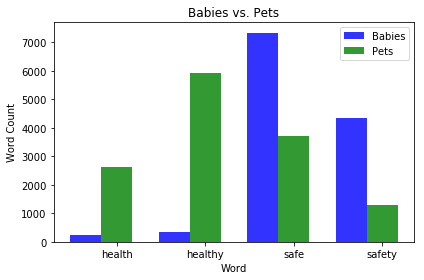

In [10]:
make_bar_graph(["health", "healthy", "safe", "safety"])

Interestingly, the concept of health appears to be much more on the mind of pet owners, while safety appears to be a bigger issue with new parents.  Now, I will look at words that might be considered to be more superficial.

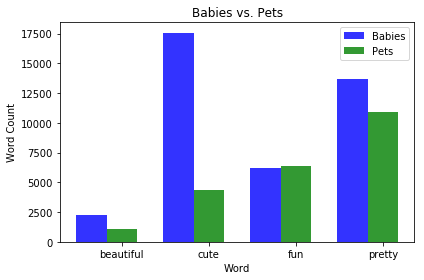

In [11]:
make_bar_graph(["cute", "beautiful", "pretty", "fun"])

It seems as if parents are more likely to use the "superficial" words, particularly in the case of 'cute'.  Finally, I will look at how important the cost of an item is to each group.

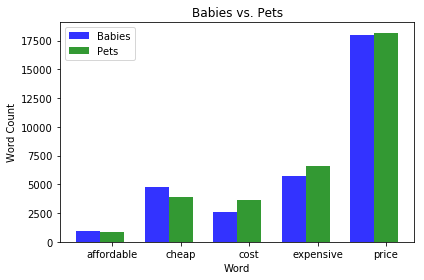

In [12]:
make_bar_graph(["cost", "price", "expensive", "cheap", "affordable"])

It seems like both groups are about equal when it comes to referencing price in a review with pet owners with a slight edge with most of the words.  The one word that parents tend to use more often is 'cheap', although it could be mentioned that that word could also be used to refer to the quality of an item rather than just its price tag.

## Stop Words

Stop words are the most commonly used words in a language (such as "the" & "to") that will not be useful in our analysis of topics.  From this point on, we will remove these words from our tokens.

In [13]:
# Import list of stop words.
stop_words = stopwords.words('english')

In [14]:
# Remove stop words from the lists of tokens.
baby_tokens_stop = [token for token in baby_tokens if not token in stop_words]
pets_tokens_stop = [token for token in pets_tokens if not token in stop_words]

## Word Clouds

A word cloud is an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance.  Producing word clouds for each of our datasets may give us some insight into what is important to our consumers.

In [15]:
# Produce word cloud for baby.
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(baby_tokens_stop))
image = wordcloud.to_image()
image.show()

BabyWordCloud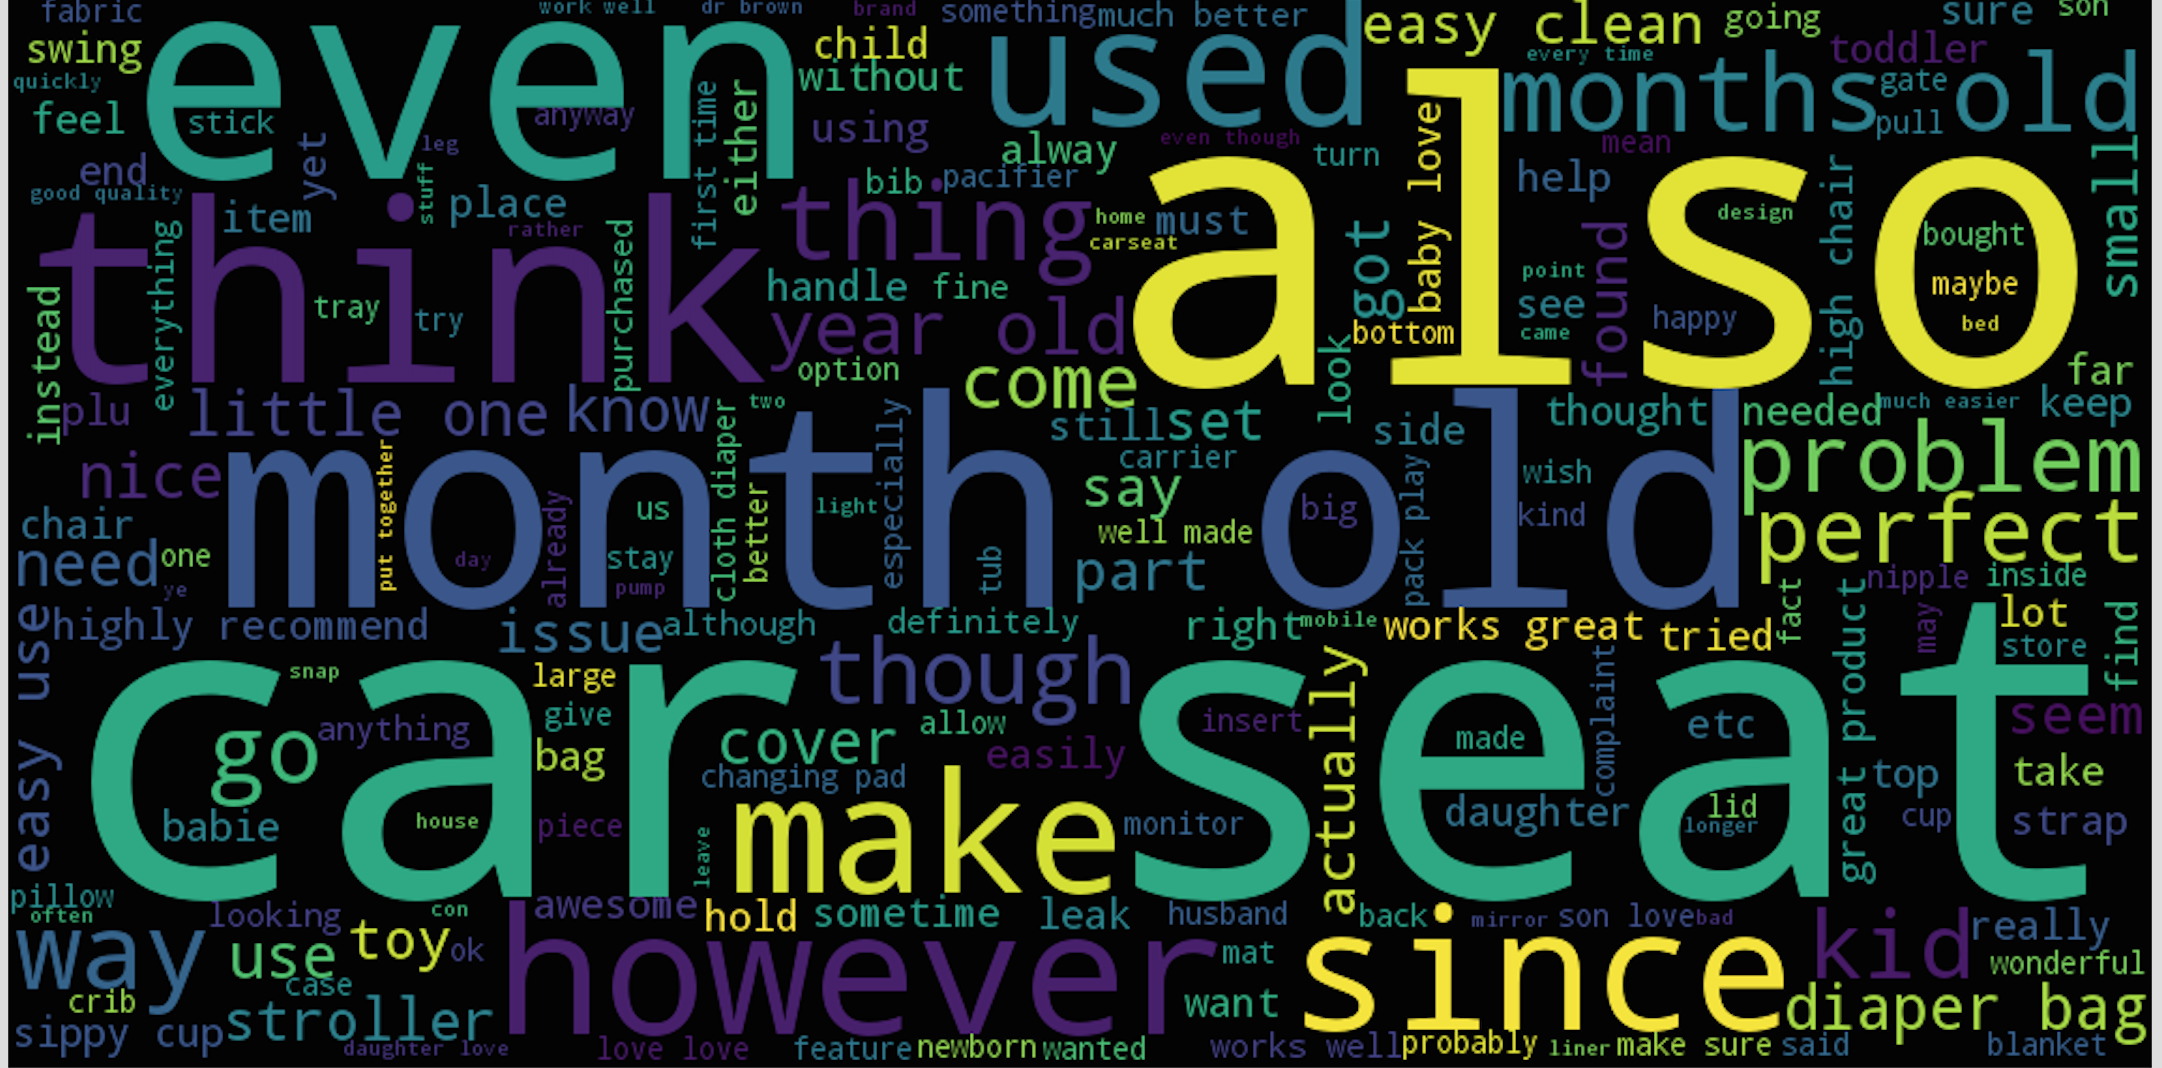

In [16]:
# Produce word cloud for pets.
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(pets_tokens_stop))
image = wordcloud.to_image()
image.show()

PetsWordCloud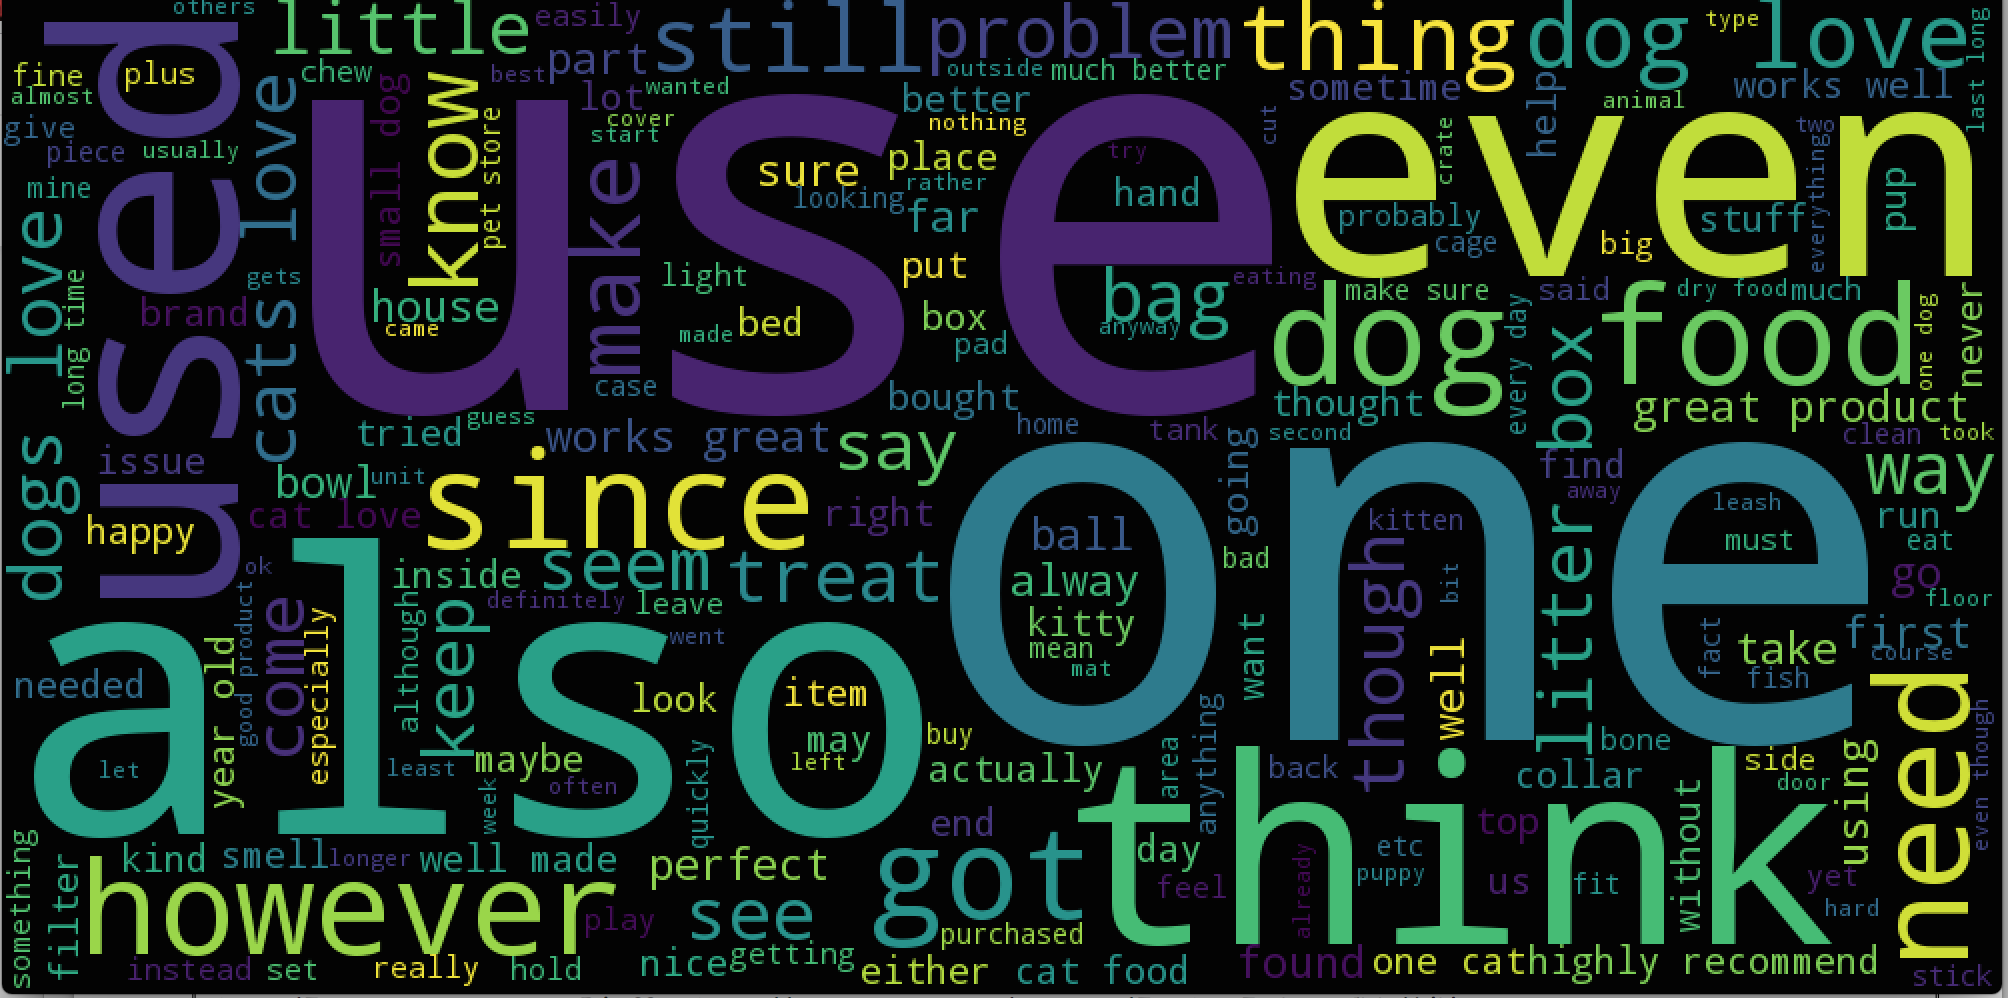

The word clouds produce many words that are not particularly useful but a few takeaways:

- The phrase 'car seat' appears prominently in the baby word cloud.  This is in line with our previously observed focus on safety.

- The phrases 'month old' and 'months old' appear in the baby cloud indicating the age/size of a baby is important when choosing a product.

- The terms 'dog food' and 'cat food' are visible in the pets word cloud which, again, confirms a previously observed focus on health from pet owners.  

- In the pet word cloud, the terms 'dogs love' and 'cats love' are visible.  Perhaps, an indication that pet owners are more focused on making their pet happy while new parents are more concerned with a baby's need.

## Preprocessing the data
In order to prepare the datasets for Latent Dirichlet Allocation, several preprocessing steps will need to be taken.  To start, due to time constraints, a sample of the datasets will be taken and then split into training and test sets.

In [17]:
# Take samples of the overall datasets and split them into training and test sets.
baby_sample = baby.sample(frac=0.2,random_state=500)
baby_train = baby_sample.sample(frac=.7,random_state=500)
baby_test = baby_sample.drop(baby_train.index)

pets_sample = pets.sample(frac=0.2,random_state=500)
pets_train = pets_sample.sample(frac=.7,random_state=500)
pets_test = pets_sample.drop(pets_train.index)

## Lemmatization
Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single 
item identified by the word's dictionary form (lemma).  After this step, for example, the words 'safe' and 'safety' will not have to be treated separately as they were at the exploratory phase.

There is a similar process called stemming which could also be used here.  However, stemming is a more crude approach that removes the endings of words to group into common forms.  Lemmatization is more complex and takes the context and meaning of the word into account.  For example, the words 'good' and 'better' have the same lemma and will be grouped by lemmatization.  As a result, lemmatization is the process that will be used here.

In [18]:
# Initialize the lemmatizer.
lemmatizer = WordNetLemmatizer()

## Data preparation
To prepare our test set for LDA, we must now put our review text through a three-step process:

1. Tokenize
2. Remove stop words
3. Lemmatize

A function is defined below to assist this process.

In [19]:
def get_tokens(df):
    
    ''' A function that takes in a dataframe with a 'fullReview' field and returns 
        a list of lists of processed tokens.'''
    
    reviews = [df['fullReview'].iloc[i] for i in range(df.shape[0])]

    review_tokens = []

    for review in reviews:
        # 3-step data processing
        tokens = tokenizer.tokenize(review.lower())
        stopped_tokens = [token for token in tokens if not token in stop_words]
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stopped_tokens]

        # Add new list of processed tokens to list
        review_tokens.append(lemmatized_tokens)
        
    return review_tokens

In [20]:
# Process tokens for each training dataset.
baby_train_tokens = get_tokens(baby_train)
pets_train_tokens = get_tokens(pets_train)

In [21]:
# Examine processed tokens.
baby_train_tokens[0:2]

[['love',
  'perfect',
  'top',
  'step',
  'wanted',
  'gate',
  'secured',
  'wall',
  'pressure',
  'mounted',
  'awesome',
  'saved',
  'banister',
  'screw',
  'hole',
  'great',
  'product'],
 ['great',
  'quality',
  'bought',
  'sister',
  'love',
  'good',
  'quality',
  'detail',
  'great',
  'handy',
  'stroller',
  'water',
  'bottle',
  'kid',
  'snack',
  'toy',
  'etc']]

## Document-term matrix
In order to generate our LDA model, we will need to have an understanding of the frequency of each word within a document.  The Dictionary function below will scan the tokens lists created above and assign each unique token an integer ID along with compiling other information such as word count.

In [22]:
# Assign integer ids to each unique token.
baby_dict = corpora.Dictionary(baby_train_tokens)
pets_dict = corpora.Dictionary(pets_train_tokens)

In [23]:
print(baby_dict)

Dictionary(22949 unique tokens: ['love', 'perfect', 'top', 'step', 'wanted']...)


## Reducing noise
We can see that the baby dictionary has 22949 unique tokens.  In order to reduce some of the noise that was evident in the word clouds above, we will filter out any tokens that appear in less than 50 documents and more than 10% of documents.

In [24]:
# Filter dictionaries to reduce noise.
baby_dict.filter_extremes(no_below=50, no_above=0.1)
pets_dict.filter_extremes(no_below=50, no_above=0.1)

In [25]:
print(baby_dict)

Dictionary(2159 unique tokens: ['top', 'step', 'wanted', 'gate', 'secured']...)


We have now reduced our baby dictionary to 2159 unique tokens.  The next step is to finalize our document-term matrix.  The doc2bow function below will convert our dictionaries above into bags of words.  The result will be a list of vectors, one for each review in our training dataset.  Each vector consists of a series of tuples where the first element of the tuple is the integer id for each word in the review and the second element is the number of times that word appears in the review.  This will complete our document-term matrix.

In [26]:
# Complete document-term matricies by creating bags of words.
baby_dtm = [baby_dict.doc2bow(token) for token in baby_train_tokens]
pets_dtm = [pets_dict.doc2bow(token) for token in pets_train_tokens]

In [27]:
# Sample vector from the baby document-term matrix.  Word #20 appears 4 times in the review while all others appear once.
baby_dtm[4]

[(8, 1), (20, 4), (41, 1), (42, 1), (43, 1), (44, 1)]

## Latent Dirichlet Allocation
It is now time to apply our LDA model.  In a nutshell, the LDA algorithm works as follows:
1. We will tell the model how many topics we think there are.  In this case, we will use 20.
2. The algorithm will assign every word to a temporary topic.  These topics are allocated according to a Dirichlet distribution (hence the name).
3. The algorithm will iterate a predetermined amount of times (again 20) checking each word and updating the topic assignment based on ow prevalent that word is across topics and how prevalent topics are in the document.

In [28]:
baby_lda = gensim.models.ldamodel.LdaModel(baby_dtm, num_topics=20, id2word = baby_dict, passes=20)

In [29]:
pets_lda = gensim.models.ldamodel.LdaModel(pets_dtm, num_topics=20, id2word = pets_dict, passes=20)

## Topics

With the LDA complete, we can now look at the results.  The command below show a list of 20 topics generated by the LDA for the baby dataset with an arbitrarily chosen number of key words, in this case 5.  The numbers before each word indicate the weight of the word in the given topic.

We can now examine each group of words and try to infer each topic.  For example, by looking at the words for topic 0, it appears to refer to diapers.  Topic 1 seems to refer to breast pumps while topic 2 is an odd mixture of bathing and sippy cups and so on. 

In [30]:
baby_lda.show_topics(num_topics=20,num_words=5)

[(0,
  '0.143*"bag" + 0.083*"diaper" + 0.028*"pocket" + 0.025*"smell" + 0.013*"hold"'),
 (1,
  '0.110*"pump" + 0.038*"milk" + 0.034*"pumping" + 0.033*"breast" + 0.031*"medela"'),
 (2,
  '0.099*"cup" + 0.048*"water" + 0.040*"tub" + 0.031*"bath" + 0.026*"sippy"'),
 (3,
  '0.027*"carrier" + 0.021*"strap" + 0.016*"leg" + 0.015*"comfortable" + 0.011*"weight"'),
 (4,
  '0.050*"monitor" + 0.033*"battery" + 0.032*"light" + 0.028*"sound" + 0.025*"spoon"'),
 (5,
  '0.038*"sleep" + 0.025*"night" + 0.014*"warm" + 0.014*"day" + 0.013*"every"'),
 (6,
  '0.031*"open" + 0.021*"door" + 0.020*"handle" + 0.019*"close" + 0.019*"clip"'),
 (7,
  '0.059*"blanket" + 0.039*"quality" + 0.033*"gift" + 0.030*"price" + 0.021*"new"'),
 (8,
  '0.107*"stroller" + 0.055*"crib" + 0.030*"mattress" + 0.021*"sheet" + 0.014*"wheel"'),
 (9,
  '0.053*"chair" + 0.042*"food" + 0.035*"clean" + 0.026*"tray" + 0.023*"potty"'),
 (10,
  '0.064*"car" + 0.020*"child" + 0.014*"mirror" + 0.013*"strap" + 0.011*"base"'),
 (11,
  '0.070*"

We can repeat the process for the pets dataset.  In this case, topic 0 seems to be about training collars.

Topics 1 & 2 are harder to infer as they seem to be made up of rather generic words, a common problem in topic analysis.

When we get to topic 3, it is somewhat easier to infer as it seems to be about pet food.

In [31]:
pets_lda.show_topics(num_topics=20,num_words=5)

[(0,
  '0.090*"collar" + 0.036*"training" + 0.028*"unit" + 0.020*"battery" + 0.017*"problem"'),
 (1,
  '0.062*"price" + 0.036*"amazon" + 0.036*"store" + 0.030*"pet" + 0.026*"hair"'),
 (2,
  '0.048*"light" + 0.035*"color" + 0.029*"black" + 0.025*"white" + 0.020*"carpet"'),
 (3,
  '0.024*"eat" + 0.020*"ingredient" + 0.016*"healthy" + 0.015*"dry" + 0.014*"chicken"'),
 (4,
  '0.015*"review" + 0.012*"worked" + 0.011*"first" + 0.011*"star" + 0.010*"week"'),
 (5, '0.042*"old" + 0.032*"kitten" + 0.029*"month" + 0.027*"1" + 0.027*"4"'),
 (6,
  '0.025*"door" + 0.025*"top" + 0.018*"plastic" + 0.016*"side" + 0.015*"open"'),
 (7,
  '0.073*"puppy" + 0.040*"ear" + 0.027*"month" + 0.026*"old" + 0.018*"pup"'),
 (8,
  '0.043*"nail" + 0.041*"cut" + 0.041*"scratch" + 0.029*"scratching" + 0.025*"clipper"'),
 (9,
  '0.040*"help" + 0.035*"flea" + 0.034*"skin" + 0.029*"coat" + 0.029*"seems"'),
 (10,
  '0.025*"say" + 0.017*"know" + 0.016*"stick" + 0.014*"kind" + 0.013*"something"'),
 (11,
  '0.030*"quality" + 

## Querying
Now we would like to take a new word or string and query the model to see what topic is most probably associated with it.  This will be best done by writing a function.  The function will have much the same structure as when we preprocessed the test data.

In [32]:
def query_model(string, dic, model):
    ''' This function will take a string, processed dictionary and an LDA model and return the topic with 
        the highest probability of being associated with that string.'''
    
    # Process the string.
    query_tokens = tokenizer.tokenize(string.lower())
    query_stopped_tokens = [word for word in query_tokens if not word in stop_words]
    query_lemmatized_tokens = [lemmatizer.lemmatize(word) for word in query_stopped_tokens]
    
    # Create document-term vector for the string.
    id2word = gensim.corpora.Dictionary()
    _ = id2word.merge_with(dic)
    query = id2word.doc2bow(query_lemmatized_tokens)
    
    # Return highest probability topic.
    topics = list(sorted(model[query], key=lambda x: x[1]))
    
    return model.print_topic(topics[-1][0])

We can now query the model with strings of interest.  Let's query the baby model with the word 'safe' that we tested above.

In [33]:
query_model("safe", baby_dict, baby_lda)

'0.064*"car" + 0.020*"child" + 0.014*"mirror" + 0.013*"strap" + 0.011*"base" + 0.011*"side" + 0.011*"install" + 0.010*"carseat" + 0.010*"safety" + 0.010*"facing"'

The topic most likely associated with 'safe' appears to relate to car seats.  Makes sense.  Let's try some other words that we experimented with previously.

In [34]:
query_model("cute", baby_dict, baby_lda)

'0.086*"cover" + 0.069*"pad" + 0.063*"cute" + 0.040*"changing" + 0.027*"mat" + 0.027*"wash" + 0.018*"washed" + 0.016*"super" + 0.015*"washing" + 0.014*"table"'

In [35]:
query_model("price", baby_dict, baby_lda)

'0.059*"blanket" + 0.039*"quality" + 0.033*"gift" + 0.030*"price" + 0.021*"new" + 0.020*"best" + 0.019*"worth" + 0.019*"swaddle" + 0.018*"item" + 0.017*"buy"'

So the word 'cute' returns a topic that seems to refer to changing and washing the baby.  Perhaps a little less obvious.

The word 'price' returns a topic possibly about blankets, but also concerned with price, quality and value.

Let's repeat the process for the pets dataset.

In [36]:
query_model("safe", pets_dict, pets_lda)

'0.054*"recommend" + 0.048*"best" + 0.042*"highly" + 0.024*"happy" + 0.023*"pad" + 0.018*"ever" + 0.017*"wonderful" + 0.013*"dish" + 0.013*"anyone" + 0.012*"recommended"'

In [37]:
query_model("cute", pets_dict, pets_lda)

'0.073*"puppy" + 0.040*"ear" + 0.027*"month" + 0.026*"old" + 0.018*"pup" + 0.018*"mix" + 0.016*"chew" + 0.015*"lab" + 0.014*"infection" + 0.014*"shepherd"'

In [38]:
query_model("price", pets_dict, pets_lda)

'0.062*"price" + 0.036*"amazon" + 0.036*"store" + 0.030*"pet" + 0.026*"hair" + 0.024*"brush" + 0.021*"buy" + 0.014*"cheaper" + 0.013*"money" + 0.013*"better"'

'Safe' returns a generic topic but one in which all of the words seem very positive about the product.  'Cute' returns a topic in which many of the terms seems to refer to puppies. Puppies are cute, right?  'Price' returns a topic in which many of the terms refer to the cost and value of the product.

Now that we can query the model, let's do it for every review in the test datasets.

In [39]:
baby_test['topic'] = baby_test['fullReview'].apply(query_model, args=(baby_dict, baby_lda))
pets_test['topic'] = pets_test['fullReview'].apply(query_model, args=(pets_dict, pets_lda))

We can see that each review in the dataset has now been assigned a most probable topic.

In [40]:
baby_test.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,fullReview,topic
104567,A2TUX40T2DWB1U,B00440CZSW,Hl2011,"[0, 0]",Great for the price. I was looking for small b...,4.0,Perfect - easy to hold,1314748800,"08 31, 2011",Perfect - easy to hold Great for the price. I ...,"0.036*""swing"" + 0.026*""play"" + 0.021*""music"" +..."
89695,A2E87NA9LNPS2C,B00384UZUU,angiepearl,"[0, 0]",This bag is awesome. It held 4 days of diaper...,5.0,Great for cloth diapers and MORE!,1322006400,"11 23, 2011",Great for cloth diapers and MORE! This bag is ...,"0.070*""diaper"" + 0.035*""cloth"" + 0.034*""bib"" +..."
9218,A2DNMHBMMK54L7,B0000DEW8N,"Stacie L. V. Davis ""Blooming Artichoke""","[0, 0]",I really love this booster. My ONLY complaint ...,5.0,Great Booster!,1298851200,"02 28, 2011",Great Booster! I really love this booster. My ...,"0.053*""chair"" + 0.042*""food"" + 0.035*""clean"" +..."
9007,A2E73W34TVKUUB,B0000DEW8N,"J. White ""JWJW2""","[0, 0]",We purchased this booster seat based on a reco...,5.0,Great Booster Seat!,1293580800,"12 29, 2010",Great Booster Seat! We purchased this booster ...,"0.053*""chair"" + 0.042*""food"" + 0.035*""clean"" +..."
51869,AOE38PHHJL1SS,B001BKVA48,"L. Soto ""lisotoa""","[0, 0]",This bottles are so good. My 4 months daughter...,5.0,Love it Love it Love it!,1374537600,"07 23, 2013",Love it Love it Love it! This bottles are so g...,"0.161*""bottle"" + 0.049*""nipple"" + 0.024*""brush..."


Let's now retrieve the top five topics for each dataset.

In [41]:
baby_test['topic'].value_counts().head()

0.015*"review" + 0.011*"buy" + 0.010*"5" + 0.010*"money" + 0.009*"day" + 0.009*"3" + 0.008*"year" + 0.008*"1" + 0.008*"price" + 0.007*"know"                            1193
0.036*"swing" + 0.026*"play" + 0.021*"music" + 0.017*"fun" + 0.017*"mobile" + 0.014*"teething" + 0.013*"cute" + 0.012*"chew" + 0.011*"teether" + 0.011*"favorite"        858
0.022*"gate" + 0.019*"pacifier" + 0.013*"plastic" + 0.011*"picture" + 0.011*"book" + 0.010*"pretty" + 0.010*"look" + 0.009*"something" + 0.009*"hard" + 0.009*"wall"     653
0.161*"bottle" + 0.049*"nipple" + 0.024*"brush" + 0.014*"brown" + 0.013*"avent" + 0.013*"dr" + 0.013*"clean" + 0.013*"flow" + 0.012*"part" + 0.012*"formula"             580
0.053*"chair" + 0.042*"food" + 0.035*"clean" + 0.026*"tray" + 0.023*"potty" + 0.020*"high" + 0.019*"table" + 0.013*"bowl" + 0.012*"easily" + 0.011*"toilet"              569
Name: topic, dtype: int64

In [42]:
pets_test['topic'].value_counts().head()

0.024*"eat" + 0.020*"ingredient" + 0.016*"healthy" + 0.015*"dry" + 0.014*"chicken" + 0.012*"flavor" + 0.011*"teeth" + 0.011*"natural" + 0.010*"picky" + 0.010*"taste"    1208
0.015*"review" + 0.012*"worked" + 0.011*"first" + 0.011*"star" + 0.010*"week" + 0.010*"could" + 0.010*"try" + 0.010*"see" + 0.009*"going" + 0.009*"since"                 990
0.067*"ball" + 0.040*"chew" + 0.027*"last" + 0.022*"bone" + 0.019*"kong" + 0.017*"long" + 0.017*"minute" + 0.017*"chewer" + 0.016*"play" + 0.013*"chewing"                891
0.086*"water" + 0.045*"tank" + 0.042*"filter" + 0.022*"fountain" + 0.022*"fish" + 0.015*"clean" + 0.013*"medium" + 0.012*"gallon" + 0.011*"aquarium" + 0.011*"pump"       704
0.038*"bag" + 0.031*"leash" + 0.022*"cage" + 0.017*"harness" + 0.016*"handle" + 0.015*"bird" + 0.014*"walk" + 0.014*"hand" + 0.010*"pull" + 0.010*"back"                  633
Name: topic, dtype: int64

Let's look at each of these topics:

Babies: Topic 1 does not appear to be about any specific product and seems very generic, possibly a lot of review on a 5-star rating.  Topic 2 is about toys/teethers.  Topic 3 seems difficult to inger.  Topic 4 is about bottles.  Topic 5 seems to be about high chairs.

Topic 1 is about food.  Topic 2 features many generic words and is hard to classify.  Topic 3 is about chew toys.  Topic 4 is about fish tanks.  Topic 5 seems to focus on leashes.

## An alternative look
While the above process provides us with a way to see which topics are most common, it is not particularly easy to read or understand.  The following tool provides us an interactive way of exploring the topics generated by the model by allowing a user to explore the meaning of each topic, how prevalent each topic is and how the topics relate to each other.  Note that the order of the topics may differ from above as this tool will only consider the training set.

In [44]:
# Interactive visualization of the baby topics.
import pyLDAvis.gensim

baby_lda_vis = pyLDAvis.gensim.prepare(baby_lda, baby_dtm, baby_dict)

In [45]:
pyLDAvis.display(baby_lda_vis)

The left panel shows the topics represented by circles, ordered by size, with the bigger circles representing more prevalent topics.  One can also easily see the calculated distance between each topic by the placement of the circle.

The right panel shows the list of words associated with each topic, the overall frequency of the word (gray bar) and the estimated frequency within the topic (red bar).  The user has the option of selecting a relevancy metric which will reassign the list of top terms based on probability.  By hovering over a word in any topic, the user can see in the left panel the conditional probability of a word over the entire set of topics.

Repeating a similar process as before, the top five baby topics are: 
1. A generic topic (same as topic 1 above)
2. Car seats
3. Generic topic focused on size
4. Baby carriers
5. Sleeping products

In [47]:
pets_lda_vis = pyLDAvis.gensim.prepare(pets_lda, pets_dtm, pets_dict)

In [48]:
pyLDAvis.display(pets_lda_vis)

Using this tool, the top five pets topics are: 
1. A generic topic (same as topic 2 above)
2. Food (same as topic 1 above)
3. Hard to classify, but focused on the physical construction of the item.
4. Litter boxes
5. Fish tanks (same as topic 4 above)

## So, do people love their pets more than their children?
To truly determine this, we would first have to answer the age-old question "What is love?" which is beyond the scope of this project.  Using the practical vs. superficial argument defined in the introduction, I don't see much of a difference in the issues that seem important to new parents or pet owners.  Whether it's car seats and leashes or dog food and baby bottles, both groups seem to care about the health and safety of those they care for rather than the more superficial qualities.

It could be noted money and price were factors in the most common baby topic.  However, given the greater cost of raising a child compared with owning a pet, it is understandable that budgeting would be more of an issue.  Also, a large number of the reviews were difficult to infer a topic.  Deeper analysis of these may yield different results.

## Next steps
While this example provides an overview of topic modeling using Latent Dirichlet Allocation, there are steps that could be taken to refine the process:
1. Using a more complete dataset: Due to time constraints, it was necessary to use a subset of the data.  I also feel that using the 5-core dataset may introduce some bias as certain products and reviewers may be overrepresented.
2. Parameter tuning: All of the parameters for the model in this example were chosen arbitrarily.  A method for optimizing the parameters would be preferable.
3. Bigrams: Allowing for two-word (or more) phrases at the preprocessing stage may infer different results.  The phrase 'car seat' appeared prominently in the word cloud, but was not visible during the final result.
4. More complex querying: The query method in this example produces the topic with the highest probability.  However, probabilities fo all of the topics are available and these could be used to create a more flexible list of topics.  "Car seats & price" vs. "Car seats & safety", for example.

## Ideas for production
Topic modelling of this nature could have wide applications in production
- A user's review history could be analyzed for important themes to that consumer as part of a recommender system.
- Government could analyze the topics of tweets by region to understand what issues are of greatest importance to the electorate in real time.
- Customer service departments could analyze incoming emails to have them automatically directed to the appropriate department.  Sentiment analysis could be added to the model to further direct the email to the appropriate person, an angry complaint being sent to a manager for example.